In [1]:
%%capture
!pip install openpyxl
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import os

In [2]:
actual_path = os.getcwd()
os.chdir('/home/onyxia/work/material_science/Spetral_clustering')
%run rbf.ipynb
os.chdir(actual_path)

In [3]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
n_samples = max_elemental.shape[0]
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
max_calculated = max_calculated.set_index('prettyformula',drop=True)
whole_data = max_elemental.merge(max_calculated,how='inner',
                                 left_index=True,right_index=True)
whole_data = whole_data.drop(['PU_label','year'],axis=1)
M_elements = pd.get_dummies(whole_data['M'],prefix='M',dtype=float)
A_elements = pd.get_dummies(whole_data['A'],prefix='A',dtype=float)
X_elements = pd.get_dummies(whole_data['X'],prefix='X',dtype=float)
whole_data = whole_data.drop(['M','A','X'],axis=1)
x_group = pd.get_dummies(whole_data['X_X_group'],prefix='x_g',dtype=float)
a_group = pd.get_dummies(whole_data['A_A_group'],prefix='a_g',dtype=float)
m_group = pd.get_dummies(whole_data['M_M_group'],prefix='m_g',dtype=float)
whole_data = whole_data.drop(['X_X_group','A_A_group','M_M_group'],axis=1)
whole_data = pd.concat([whole_data,M_elements,A_elements,X_elements,x_group,
                       a_group,m_group],axis=1)

test_tree = DecisionTreeClassifier().fit(X=whole_data.drop(['class'],axis=1),
                                                              y=whole_data['class'])

imp_feat = test_tree.feature_importances_
names_feat = test_tree.feature_names_in_

imp_feat = imp_feat.reshape(-1,1)
names_feat = names_feat.reshape(-1,1)
test_df = pd.DataFrame(np.hstack((names_feat,imp_feat)))
test_df.columns = ['names_feat','imp_feat']
test_df = test_df.set_index('names_feat',drop=True)
test_df = test_df[test_df['imp_feat'] > 0]

diff_z = list(test_df.index)


number_of_atoms = np.zeros(n_samples)
compteur = 0
for element in whole_data.index:
    inter = []
    for cara in element:
        if cara in list(str(1234567890)):
            inter.append(cara)
    if len(inter) == 1:
        number_of_atoms[compteur] = int(inter[0]) + 2
    elif len(inter) == 2:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + 1
    elif len(inter) == 3:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + int(inter[2])
    compteur += 1

columns_name = whole_data.drop(['class'],axis=1).columns.copy()
normalized = whole_data.drop(['class'],axis=1).to_numpy()/number_of_atoms.reshape(-1,1)

data_norm = pd.DataFrame(normalized)
data_norm.columns = columns_name
data_norm['compound_name'] = whole_data.index
data_norm = data_norm.set_index('compound_name',drop=True)

data_norm = data_norm.filter(items=list(diff_z),axis=1)
data_norm['class'] = whole_data['class'].copy()

retained_features = list(test_df.index)

for feat in diff_z:
    if len(feat) > 6:
        retained_features.remove(feat)

list_dummies = []

for i in retained_features:
    if 'M_' in i:
        list_dummies.append(i)
    elif 'A_' in i:
        list_dummies.append(i)
    elif 'X_' in i:
        list_dummies.append(i)
    elif 'm_g_' in i:
        list_dummies.append(i)
    elif 'a_g_' in i:
        list_dummies.append(i)
    elif 'x_g_' in i:
        list_dummies.append(i)
        
for col in list_dummies:
    for row in data_norm.index:
        if data_norm.loc[row,col] != 0:
            data_norm.loc[row,col] = 1

In [4]:
data_norm['label'] = np.zeros(n_samples)
for i in data_norm.index:
    if data_norm.loc[i,'class'] == 1:
        data_norm.loc[i,'label'] = 1
    else:
        data_norm.loc[i,'label'] = -1
positive_samples = data_norm[data_norm['label'] == 1]
unlabelled_samples = data_norm[data_norm['label'] == -1]

In [5]:
list_of_imp_elem = list(positive_samples.index)
predictions_pos = np.zeros(15)
proba_pos = np.zeros(15)
count_elem = 0
for elem_part in list_of_imp_elem:
    max_elem_norm = data_norm.drop(elem_part,axis=0)
    n_samples = max_elem_norm.shape[0]
    #modification to fit with the previous versions
    n_cluster = 8
    clustering = KMeans(n_clusters=n_cluster).fit(X=max_elem_norm.to_numpy()[:,:-2])
    max_elem_norm['cluster'] = clustering.labels_
    list_of_ratio = np.zeros(n_cluster)
    for i in range(n_cluster):
        list_of_ratio[i] = max_elem_norm[max_elem_norm['cluster'] == i]['class'].sum()/max_elem_norm[max_elem_norm['cluster'] == i].shape[0]
    #same code as before but here we use the class because it is 0 or 1
    positive_cluster = np.argmax(list_of_ratio)
        
    #we cannot exactly compute the ratios because the classes are so unbalanced that in any cases the number of positive
    #instances will be very small compared to the ones of unlabelled instances
    
    list_of_dist = np.zeros(n_cluster)
    for i in range(n_cluster):
        list_of_dist[i] = np.linalg.norm(clustering.cluster_centers_[positive_cluster,:] - clustering.cluster_centers_[i,:])
    
    negative_cluster = np.argmax(list_of_dist)
    df_unlab_pop = max_elem_norm[max_elem_norm['label'] == -1]
    list_of_pop = pd.DataFrame(df_unlab_pop.groupby('cluster')['label'].count())
    list_of_pop.columns = ['pop']
    list_of_pop['dist'] = list_of_dist #distance to the positive cluster
    list_of_pop = list_of_pop.sort_values('dist',ascending=False)
    list_of_pop['cumsum'] = np.cumsum(list_of_pop['pop'])
    reliable_positives = max_elem_norm[max_elem_norm['label'] == 1]
    n_positives = reliable_positives.shape[0]
    last_step = np.where(np.array(list_of_pop['cumsum'])>n_positives*10)[0][0]
    index_ordered_distance = list(list_of_pop.index)
    if last_step == 0:
        reliable_negatives = max_elem_norm[max_elem_norm['cluster'] == negative_cluster]
        reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
    else:
        compteur=0
        reliable_negatives = max_elem_norm[max_elem_norm['cluster'] == negative_cluster]
        reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
        while compteur<last_step:
            interm_negatives = max_elem_norm[max_elem_norm['cluster'] == index_ordered_distance[compteur+1]]
            interm_negatives = interm_negatives[interm_negatives['label'] == -1]
            reliable_negatives = pd.concat([reliable_negatives,interm_negatives])
            compteur += 1
        del interm_negatives, compteur
    
    reliable_negatives = reliable_negatives.head(n=n_positives*10)
    
    #Step of initialization of labels
    train_clf_data = pd.concat([reliable_positives,reliable_negatives])
    index_of_labels = list(train_clf_data.index)
    unlabelled_data = max_elem_norm.drop(labels=index_of_labels,axis=0)
    index_of_unlabelled = list(unlabelled_data.index)
    first_step_clf = SVC().fit(X=train_clf_data.drop(['class','label','cluster'],axis=1).to_numpy(),
                              y=train_clf_data['label'].to_numpy())
    unlabelled_data['relab'] = first_step_clf.predict(unlabelled_data.drop(['class','label','cluster'],axis=1).to_numpy())

    gamma = 1
    good_ratio = 1/10
    max_iter = 10
    compteur = 0
    train_clf_data['relab'] = train_clf_data['label'].copy()
    updated_data = pd.concat([train_clf_data,unlabelled_data])
    up_data_np = updated_data.to_numpy()[:,:-4].copy()
    positive_index_list = list(max_elem_norm[max_elem_norm['class'] == 1].index)

    right_side = np.vstack((np.zeros(1).reshape(1,1),np.ones(n_samples).reshape(n_samples,1))) #its for the 
    #computation of the matrix to det the coeffs so put it here to avoid doing it each time
    while compteur<max_iter:
        compteur += 1
        labels = updated_data['relab'].to_numpy().reshape(1,-1)
        first_row = np.hstack((np.array(0).reshape(1,1),(-1)*labels))
        
        #computation of omega and the coefficients
        omega = np.zeros((n_samples,n_samples))
        for i in range(n_samples):
            for k in range(i,n_samples):
                omega[i,k] = rbf(x=up_data_np[i,:],y=up_data_np[k,:],l_squared=50)*labels[0,i]*labels[0,k]
                omega[k,i] = omega[i,k]
            omega[i,i] = 1
    
        bot_right = omega + gamma*np.eye(n_samples)
        bot = np.hstack((updated_data['relab'].to_numpy().reshape(n_samples,1), bot_right))
        whole_mat = np.vstack((first_row, bot))
        
        del bot_right, bot, first_row
    
        coeffs = np.linalg.solve(a=whole_mat,b=right_side)


        alpha = coeffs[1:]
    
        #once we have the coefficients, we can compute the labels of the unlabelled instances
    
        updated_data['to_det_b'] = np.zeros(n_samples)
        for_loop_count = 0
        for i in updated_data.index:
            updated_data.loc[i,'to_det_b'] = np.sum(alpha*labels.reshape(-1,1)*rbf(x=up_data_np,y=up_data_np[for_loop_count,:],l_squared=50).reshape(-1,1))
            for_loop_count += 1
    
        to_det_b_arr = np.array(updated_data['to_det_b']).copy()
        b = np.sort(to_det_b_arr)[int((1-good_ratio)*n_samples)]
        
        updated_data['check_array'] = np.zeros(n_samples)
        count_diff = 0
        
        for i in updated_data.index:
            if i in positive_index_list:
                updated_data.loc[i,'check_array'] = 1
            else:
                updated_data.loc[i,'check_array'] = np.sign(updated_data.loc[i,'to_det_b']-b)
                if updated_data.loc[i,'check_array'] != updated_data.loc[i,'relab']:
                    count_diff += 1
        
        if count_diff == 0:
            break
        else:
            updated_data['relab'] = updated_data['check_array'].copy()


    predictions_pos[count_elem] = np.sign(np.sum(alpha*labels.reshape(-1,1)*rbf(x=up_data_np,
                                                                                y=data_norm.loc[elem_part,:].to_numpy().reshape(1,-1)[:,:-2],
                                                                                l_squared=50).reshape(-1,1))-b)
                                 
    positives_whole = 0
    for i in updated_data.index:
        if updated_data.loc[i,'relab'] == 1:
            positives_whole += 1
    positives_whole += -14
    #-14 because at each iteration we fix the known positives as positives, so there are 
    #14 predictions that are not truely predictions
    proba_pos[count_elem] = positives_whole/(updated_data.shape[0]-14)
    count_elem += 1


In [6]:
predictions_pos

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1.])

In [7]:
b

np.float64(0.841382029859042)

In [8]:
true_positives_pred = 0
for i in predictions_pos:
    if i == 1:
        true_positives_pred += 1

In [9]:
true_positives_pred

0

In [10]:
recall = true_positives_pred/15

In [11]:
recall

0.0

In [12]:
#very bad result, but, maybe, we should use more points on the first sampling even if it
#doesnt respect r, because when it was set to 50, the results seem a bit better

In [13]:
results_of_pred = pd.DataFrame(list_of_imp_elem)

In [14]:
results_of_pred['result'] = predictions_pos

In [15]:
results_of_pred.columns = ['name','result']

In [16]:
results_of_pred = results_of_pred.set_index('name',drop=True)

In [17]:
results_of_pred = results_of_pred.merge(max_calculated,how='left',left_index=True,right_index=True)

In [27]:
true_positives_df = results_of_pred[results_of_pred['result'] == 1]
false_negative = results_of_pred.drop(list(true_positives_df.index),axis=0)
remaining_to_plot = max_calculated.drop(list(results_of_pred.index),axis=0)
list_to_see = list(updated_data[updated_data['relab'] == 1].index)
imp_to_see = max_calculated.filter(list_to_see,axis=0)

In [19]:
import matplotlib.pyplot as plt

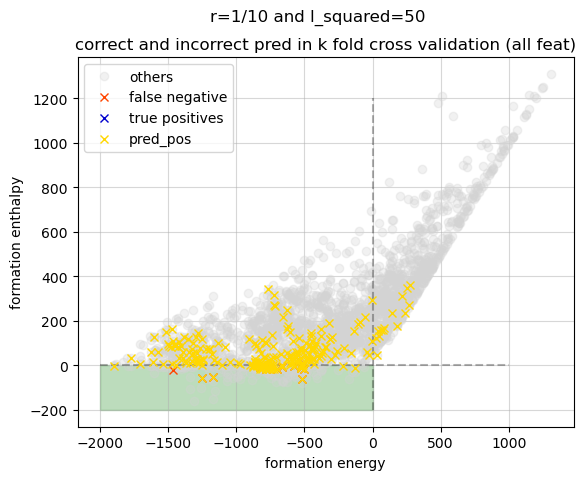

In [29]:
fig, ax = plt.subplots()
ax.grid(alpha=0.5)
ax.plot(remaining_to_plot['dEf'],remaining_to_plot['dH'], 'o', color='lightgrey', alpha=0.3,
        label='others')
ax.plot(np.linspace(-2000,1000,2,endpoint=True),np.zeros(2),'k--',alpha=0.3)
ax.plot(np.zeros(2),np.linspace(-200,1200,2,endpoint=True),'k--',alpha=0.3)
ax.fill_between(np.linspace(-2000,0,2,endpoint=True),y1=-200,y2=0,color='forestgreen',alpha=0.3)
ax.plot(false_negative['dEf'],false_negative['dH'],'x',color='orangered',
        label='false negative')
ax.plot(true_positives_df['dEf'],true_positives_df['dH'],'x',color='mediumblue',
        label='true positives')
ax.plot(imp_to_see['dEf'],imp_to_see['dH'],'x',color='gold',
        label='pred_pos')
ax.set_xlabel('formation energy')
ax.set_ylabel('formation enthalpy')
ax.set_title('correct and incorrect pred in k fold cross validation (all feat)')
plt.suptitle('r=1/10 and l_squared=50')
plt.legend()
#plt.savefig('pred_k-fold_cross_v_10_10.png')

In [21]:
test = alpha*labels.reshape(-1,1)

In [22]:
test.shape

(2261, 1)

In [24]:
b

np.float64(0.841382029859042)

In [30]:
updated_data[updated_data['class'] == 1]

,M_M_average_cationic_radius,A_A_atomic_number,c,dMX,dMA,rMA,e_M,e_X,dEc,density,...,M_Ti,M_V,A_Sn,A_Zn,class,label,cluster,relab,to_det_b,check_array
compound_name,,,,,,,,,,,,,,,,,,,,,
Ti2AlC,0.212917,3.250000,3.434875,0.286710,0.572010,0.723328,0.329452,-0.481092,1585.313992,0.999209,...,1.0,0.0,0.0,0.0,1.0,1.0,1,1.0,0.871406,1.0
Ti2SC,0.212917,4.000000,2.817900,0.279593,0.424882,0.627973,0.383445,-0.468533,1705.123542,1.158582,...,1.0,0.0,0.0,0.0,1.0,1.0,1,1.0,1.017466,1.0
Ti2ZnC,0.212917,7.500000,3.441525,0.288608,0.571775,0.722298,0.335172,-0.483255,1396.775752,1.289542,...,1.0,0.0,0.0,1.0,1.0,1.0,6,1.0,0.767331,1.0
V2AlC,0.194375,3.250000,3.282425,0.279170,0.541435,0.685475,0.237250,-0.411033,1507.684761,1.212639,...,0.0,1.0,0.0,0.0,1.0,1.0,6,1.0,0.841382,1.0
Nb2AlC,0.205000,3.250000,3.485475,0.311915,0.559453,0.719043,0.241175,-0.426833,1702.981879,1.578442,...,0.0,0.0,0.0,0.0,1.0,1.0,1,1.0,0.952208,1.0
Ta2AlC,0.205000,3.250000,3.491000,0.314817,0.557933,0.714878,0.236375,-0.456950,1884.426031,2.870454,...,0.0,0.0,0.0,0.0,1.0,1.0,5,1.0,0.844345,1.0
Ti3AlC2,0.141944,2.166667,3.109183,0.197525,0.382243,0.483758,0.238270,-0.300678,1128.862198,0.702228,...,1.0,0.0,0.0,0.0,1.0,1.0,0,1.0,1.584618,1.0
Ti3SiC2,0.141944,2.333333,2.955250,0.199508,0.339795,0.450538,0.248850,-0.296233,1168.330449,0.746292,...,1.0,0.0,0.0,0.0,1.0,1.0,0,1.0,1.342699,1.0
Ti3ZnC2,0.141944,5.000000,3.103967,0.197908,0.380173,0.481942,0.243088,-0.302950,1046.059042,0.843894,...,1.0,0.0,0.0,1.0,1.0,1.0,0,1.0,1.514914,1.0
